Available DWLR IDs: ['DWLR-1' 'DWLR-2' 'DWLR-3' 'DWLR-4' 'DWLR-5' 'DWLR-6' 'DWLR-7' 'DWLR-8'
 'DWLR-9' 'DWLR-10' 'DWLR-11' 'DWLR-12' 'DWLR-13' 'DWLR-14' 'DWLR-15'
 'DWLR-16' 'DWLR-17' 'DWLR-18' 'DWLR-19' 'DWLR-20' 'DWLR-21' 'DWLR-22'
 'DWLR-23' 'DWLR-24' 'DWLR-25' 'DWLR-26' 'DWLR-27' 'DWLR-28' 'DWLR-29'
 'DWLR-30' 'DWLR-31' 'DWLR-32' 'DWLR-33' 'DWLR-34' 'DWLR-35' 'DWLR-36'
 'DWLR-37' 'DWLR-38' 'DWLR-39' 'DWLR-40' 'DWLR-41' 'DWLR-42' 'DWLR-43'
 'DWLR-44' 'DWLR-45' 'DWLR-46' 'DWLR-47' 'DWLR-48' 'DWLR-49' 'DWLR-50']


Enter the DWLR ID for trend analysis:  DWLR-3


C:\Users\PRADIP\AppData\Local\Temp\ipykernel_2352\1985187960.py:42: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='time', limit_direction='both', inplace=True)


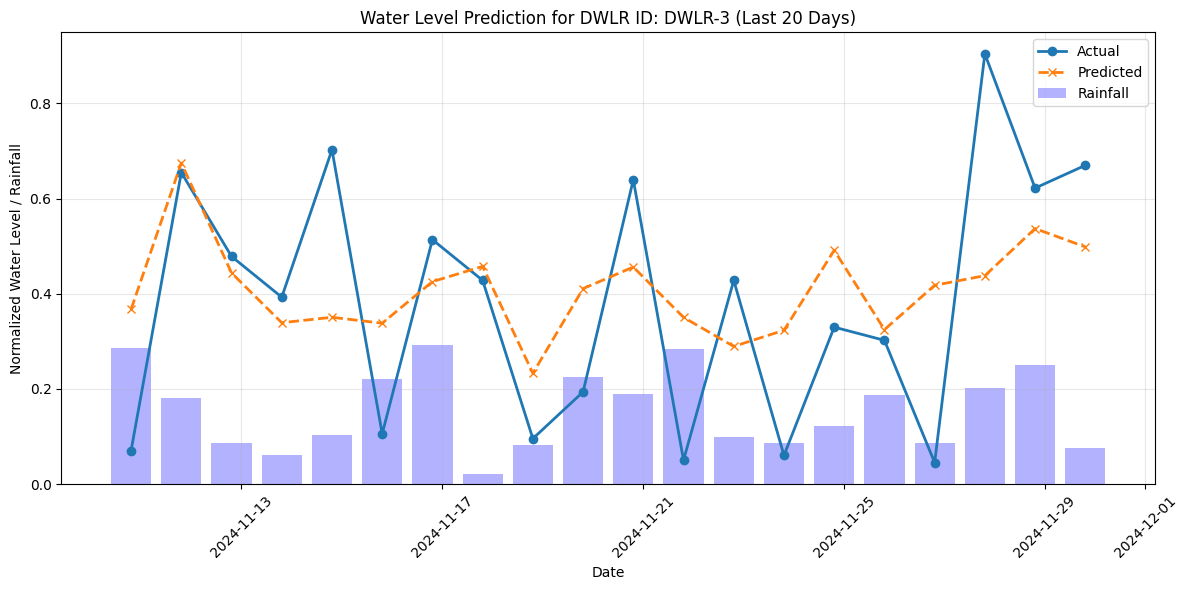


Mean Absolute Error for DWLR DWLR-3: 0.20314736939363168

Top 10 Most Important Features:
                         feature  importance
25   water_level_rolling_mean_7d    0.085481
37                 season_winter    0.047206
28  water_level_rolling_mean_14d    0.045046
7              water_level_lag_5    0.040600
16             temperature_lag_4    0.036787
3              water_level_lag_1    0.033361
19                rainfall_lag_2    0.032718
22                rainfall_lag_5    0.031831
31  water_level_rolling_mean_30d    0.031683
24                rainfall_lag_7    0.031445


In [2]:
from pymongo import MongoClient 
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from datetime import timedelta
from dotenv import load_dotenv
import os

load_dotenv()

MONGO_URI = os.getenv("MONGO_URI")

def add_lag_features(df, target, lags):
    for lag in range(1, lags + 1):
        df[f"{target}_lag_{lag}"] = df.groupby('dwlr_id')[target].shift(lag)
    return df

client = MongoClient(MONGO_URI)
db = client["water_level_db"]
collection = db["water_level_data"]
cursor = collection.find({}, {"_id": 0})
all_data = pd.DataFrame(list(cursor))

# Get available DWLR IDs and user input
available_dwlrs = all_data['dwlr_id'].unique()
print("Available DWLR IDs:", available_dwlrs)
selected_dwlr = input("Enter the DWLR ID for trend analysis: ")

# Filter data for selected DWLR
data = all_data[all_data['dwlr_id'] == selected_dwlr].copy()

if len(data) == 0:
    raise ValueError("No data found for the selected DWLR ID")

# [Rest of the preprocessing and model training code remains the same]
data["date"] = pd.to_datetime(data["date"])
data.set_index("date", inplace=True)
data = data.sort_values(by=["dwlr_id", "date"])
data.interpolate(method='time', limit_direction='both', inplace=True)

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

data = remove_outliers_iqr(data, "water_level")

scaler = MinMaxScaler()
data[["water_level", "temperature", "rainfall"]] = scaler.fit_transform(
    data[["water_level", "temperature", "rainfall"]]
)

def create_features(df):
    df = add_lag_features(df, "water_level", lags=10)
    df = add_lag_features(df, "temperature", lags=5)
    df = add_lag_features(df, "rainfall", lags=7)
    
    windows = [7, 14, 30]
    for window in windows:
        df[f'water_level_rolling_mean_{window}d'] = df.groupby('dwlr_id')['water_level'].transform(lambda x: x.rolling(window=window).mean())
        df[f'rainfall_rolling_sum_{window}d'] = df.groupby('dwlr_id')['rainfall'].transform(lambda x: x.rolling(window=window).sum())
        df[f'temp_rolling_mean_{window}d'] = df.groupby('dwlr_id')['temperature'].transform(lambda x: x.rolling(window=window).mean())
    
    df['rainfall_temp_interaction'] = df['rainfall'] * df['temperature']
    df['dry_condition'] = ((df['temperature'] > df['temperature'].mean()) & 
                          (df['rainfall'] < df['rainfall'].mean())).astype(int)
    
    df['month'] = df.index.month
    df['season'] = pd.cut(df.index.month, bins=[0,3,6,9,12], labels=['winter','spring','summer','fall'])
    df = pd.get_dummies(df, columns=['season'])
    
    return df

data = create_features(data)
data.dropna(inplace=True)

X = data.drop(columns=["dwlr_id", "state", "district", "water_level"])
y = data["water_level"]

split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Updated visualization with DWLR ID in title
plt.figure(figsize=(12, 6))
plot_range = slice(-20, None)
plt.plot(y_test.index[plot_range], y_test[plot_range], 
         label="Actual", marker='o', linewidth=2)
plt.plot(y_test.index[plot_range], y_pred[plot_range], 
         label="Predicted", marker='x', linewidth=2, linestyle='--')

rainfall_scaled = data.loc[y_test.index[plot_range], 'rainfall']
plt.bar(y_test.index[plot_range], rainfall_scaled * 0.3, 
        alpha=0.3, color='blue', label='Rainfall')

plt.title(f"Water Level Prediction for DWLR ID: {selected_dwlr} (Last 20 Days)")
plt.xlabel("Date")
plt.ylabel("Normalized Water Level / Rainfall")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

mae = mean_absolute_error(y_test, y_pred)
print(f"\nMean Absolute Error for DWLR {selected_dwlr}: {mae}")

importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(importance.head(10))

In [3]:
prediction_results = pd.DataFrame({
    'Date': y_test.index[plot_range],
    'Actual': y_test[plot_range].values,
    'Predicted': y_pred[plot_range],
    'Rainfall': rainfall_scaled.values
})
print("\nPrediction Results for Last 20 Days:")
print(prediction_results.to_string(index=False))


Prediction Results for Last 20 Days:
                   Date   Actual  Predicted  Rainfall
2024-11-10 19:20:09.897 0.070529   0.367544  0.953498
2024-11-11 19:20:09.897 0.654912   0.674992  0.604931
2024-11-12 19:20:09.897 0.478589   0.443907  0.288034
2024-11-13 19:20:09.897 0.392947   0.339269  0.205853
2024-11-14 19:20:09.897 0.702771   0.350677  0.347364
2024-11-15 19:20:09.897 0.105793   0.338229  0.739427
2024-11-16 19:20:09.897 0.513854   0.425648  0.972740
2024-11-17 19:20:09.897 0.428212   0.457559  0.067749
2024-11-18 19:20:09.897 0.095718   0.233038  0.277009
2024-11-19 19:20:09.897 0.193955   0.410964  0.752656
2024-11-20 19:20:09.897 0.639798   0.456264  0.633594
2024-11-21 19:20:09.897 0.050378   0.350509  0.946482
2024-11-22 19:20:09.897 0.428212   0.289487  0.333133
2024-11-23 19:20:09.897 0.060453   0.323423  0.286430
2024-11-24 19:20:09.897 0.329975   0.491528  0.405492
2024-11-25 19:20:09.897 0.302267   0.324735  0.622570
2024-11-26 19:20:09.897 0.045340   0.417857 